In [1]:
#!/usr/bin/env python3
import tensorflow as tf

import os
import matplotlib as mpl
import matplotlib.pyplot as plt 
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from matplotlib.ticker import FixedLocator, FixedFormatter, FuncFormatter, MultipleLocator

from src.ForecastModel.utils.metrics import calculate_nse, calculate_kge, calculate_bias, load_metrics
from src.ForecastModel.utils.postprocessing import ModelHandler

import numpy as np
import pandas as pd

plt.rcParams.update({
    "text.usetex": False,
    'font.size'   : 8,
})

In [2]:
PLOT_PATH = r"plots"
DATA_PATH = r"src\data\Dataset.csv"

In [11]:
models = {
    "arima-boxcox": ModelHandler("ARIMA-BOXCOX",
                r"rst\ARIMA-BOXCOX",
                is_final_model = True,
                is_external_model = True,
                color = "#E69F00",
                ls = "--",
                  ),
     "pbhm-hlstm": ModelHandler("PBHM-HLSTM",
                   r"rst\PBHM-HLSTM",
                   is_final_model = True,
                   color = "#56B4E9",
                   ls = "-",
                 ),
     "elstm": ModelHandler("eLSTM",
                   r"rst\eLSTM",
                   is_final_model = True,
                   color = "#D55E00",
                   ls = "-",
                 ),
     }


In [4]:
# calculate metrics of hydrologic model per fold
dfh = pd.read_csv(DATA_PATH, parse_dates=['time'])

hyd_metrics = {}
for year in range(2012, 2018):
      dfp = dfh.loc[dfh["time"].dt.year == year]
      hyd_metrics[year] = {
          "kge":  calculate_kge(dfp.qmeasval.values, dfp.qsim.values),
          "nse":  calculate_nse(dfp.qmeasval.values, dfp.qsim.values),
          "bias": calculate_bias(dfp.qmeasval.values, dfp.qsim.values),
      }    
    

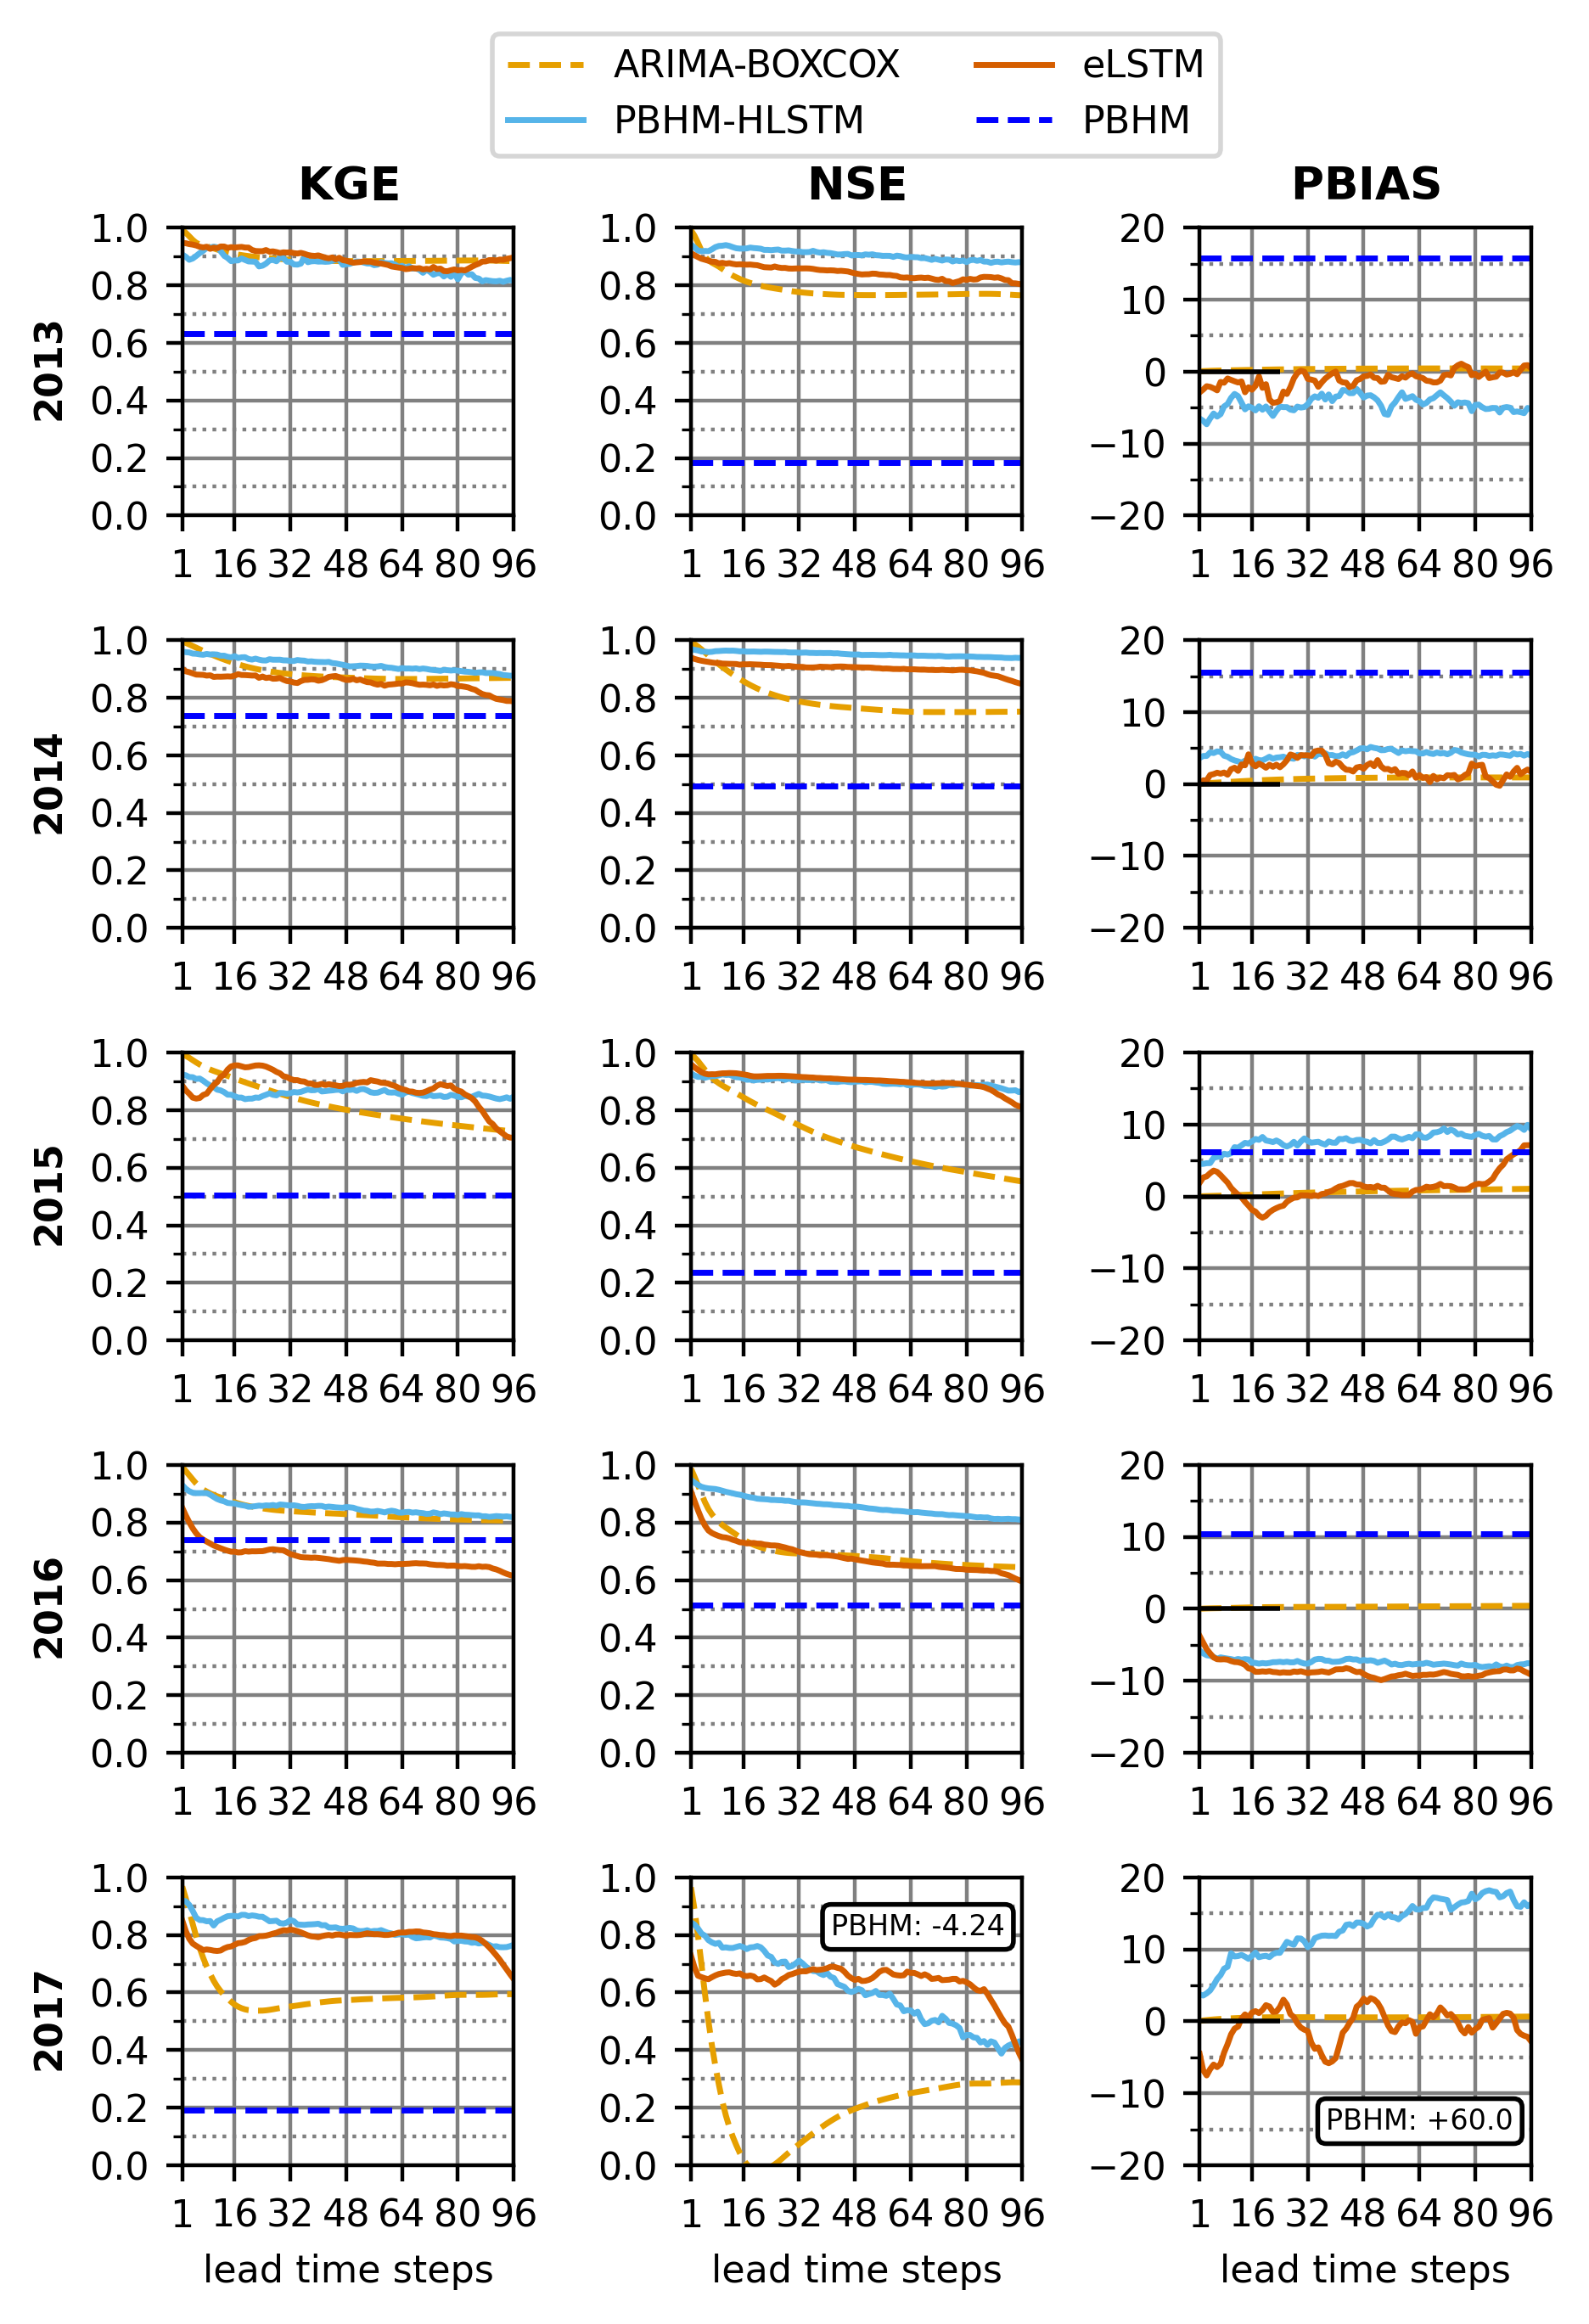

In [13]:
fig, axes = plt.subplots(5,3,figsize=(4.72,6.5), dpi=400)

metric_names = ["kge", "nse", "bias"]
metric_labels = ["KGE", "NSE", "PBIAS"]
ylims = [(0,1), (-2,1), (-20,10)]


xx = np.arange(1,97)
df = pd.DataFrame(columns=["name", "year", 
                           "kge_pass", "nse_pass", "bias_pass",
                           "kge_min", "kge_avg", "kge_max", 
                           "nse_min", "nse_avg", "nse_max", 
                           "bias_min", "bias_avg", "bias_max"])

n_row = -5
for n, key in enumerate(models.keys()):
    metrics = load_metrics(os.path.join(models[key].lg_path, "metrics_eval.txt"))
    
    n_row += 5
    for j, met in enumerate(metric_names):
        metric  = metrics["test"][met]
        for i in range(5):
            df.loc[n_row+i, ["name", "year"]] = [models[key].name, 2013+i]
            df.loc[n_row+i, [f"{met}_min", f"{met}_avg", f"{met}_max"]] = [np.min(metric[i]), 
                                                                           np.mean(metric[i]), 
                                                                           np.max(metric[i])]
            df.loc[n_row+i, [f"{met}_{x}" for x in range(96)]] = [metric[i][x] for x in range(96)]
            xx = np.arange(1,np.array(metric[i]).shape[0]+1)
            axes[i,j].plot(xx, metric[i], color=models[key].color, ls=models[key].ls, label=f"{models[key].name}", lw=1.25)


for i in range(5):
    for j in range(3):
        if i == 0:
            axes[i,j].set_title(r"$\bf{"+f"{metric_labels[j]}"+r"}$")
        elif i == 4:
            axes[i,j].set_xlabel("lead time steps")
        if j == 0:
            axes[i,j].set_ylabel(r"$\bf{"+f"{2013 + i}"+r"}$")

        axes[i,j].hlines(hyd_metrics[2013+i][metric_names[j]], 1, 96, color="b", ls = "--", label="PBHM", lw=1.25)
        if (i == 4) & (j == 1):
            metric_hyd = hyd_metrics[2013+i][metric_names[j]]
            axes[i,j].text(91,0.8, f"PBHM: {metric_hyd:+4.2f}", color="k", ha="right", fontsize=6,
                     bbox={"boxstyle": "round",
                               "ec":(0, 0, 0),
                               "fc":(1., 1, 1),
                     })
        if (i == 4) & (j == 2):
            metric_hyd = hyd_metrics[2013+i][metric_names[j]]
            axes[i,j].text(91,-15, f"PBHM: {metric_hyd:+4.1f}", color="k", ha="right", fontsize=6,
                     bbox={"boxstyle": "round",
                               "ec":(0, 0, 0),
                               "fc":(1., 1, 1),
                     })
            
            
        axes[i,j].set_xticks([1,16,32,48,64,80,96])
        if j == 2:
            axes[i,j].yaxis.set_major_locator(MultipleLocator(10))
            axes[i,j].yaxis.set_minor_locator(MultipleLocator(5))
            axes[i,j].set_ylim((-20,20))
            axes[i,j].hlines(0, 0, 24, color="k", lw=1)
        else:
            axes[i,j].yaxis.set_major_locator(MultipleLocator(0.2))
            axes[i,j].yaxis.set_minor_locator(MultipleLocator(0.1))
            axes[i,j].set_ylim((0,1))

        axes[i,j].set_xlim((1,96))
        
        axes[i,j].grid(which='major', color='grey', linestyle='-')
        axes[i,j].grid(which='minor', color='grey', linestyle=':')

fig.tight_layout()
axes[0,1].legend(bbox_to_anchor=(0.5, 1.25), 
                 loc='lower center', ncol=2, 
                 borderaxespad=0)


In [14]:
# save figure
fig.savefig(os.path.join(PLOT_PATH, 'fig5_leadtime_performance-all.png'), bbox_inches="tight", dpi=300)